## Applying the XGBoost algorithm ##

In [68]:
import pandas as pd
import numpy as np

# from keras.wrappers.scikit_learn import KerasRegressor
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import KFold
# from sklearn.preprocessing import StandardScaler # needed?
import xgboost as xgb

from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
# from sklearn.pipeline import Pipeline
# import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

# for reading files
import glob
import os
from datetime import datetime
import seaborn as sns

%matplotlib inline
import matplotlib.pyplot as plt

In [227]:
# input dataset
input_file = "./data/processed/all_combined_training.csv"
validation_file = "./data/processed/all_combined_validation.csv"
# TODO: XGBoost parameters

In [228]:
# load data
df = pd.read_csv(input_file, index_col = 0)
dfc=df.copy()

In [229]:
dfc.tail(3) 
# dfc['year'].unique()

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C)
236518,2015,12,31,21,365.311750,60.01732,-70.02754,567,582.943444,-19.845023
236519,2015,12,31,22,361.482583,60.01732,-70.02754,567,582.943444,-20.679938
236520,2015,12,31,23,358.839000,60.01732,-70.02754,567,582.943444,-21.149695


In [230]:
dfc['date'] = pd.to_datetime(dfc[['year', 'month', 'day']])
# dfc.keys(), df.keys()
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp (°C),date
85690,2013,10,13,10,277.417667,61.03000,-69.62000,403,463.473224,2.250391,2013-10-13
219155,2014,1,7,10,475.439250,60.01732,-70.02754,567,582.943444,-8.863379,2014-01-07


In [231]:
dfc.rename(columns={"Temp (°C)":"Temp"}, inplace=True)
dfc.sample(2)

,year,month,day,hour,Kw,lat,lon,population,annual_peak_load,Temp,date
120623,2014,10,8,23,178.666667,59.31042,-69.59216,209,308.388576,1.77041,2014-10-08
34714,2013,12,18,10,1304.639833,58.45424,-78.10301,1757,1662.384400,-14.67417,2013-12-18


## Power consumption per capita

In [232]:
dfc['Kw_per_capita'] = dfc['Kw']/df['population']
dfc.drop(['Kw', 'population', 'annual_peak_load','year','month','day','hour','lon','Temp'],
         axis = 1, inplace = True)

In [233]:
dfc

,lat,date,Kw_per_capita
0,55.27987,2013-01-01,1.916213
1,55.27987,2013-01-01,1.888308
2,55.27987,2013-01-01,1.867942
3,55.27987,2013-01-01,1.792413
4,55.27987,2013-01-01,1.727252
...,...,...,...
236516,60.01732,2015-12-31,0.640062
236517,60.01732,2015-12-31,0.648297
236518,60.01732,2015-12-31,0.644289
236519,60.01732,2015-12-31,0.637535


## Data by location: creates 9 dataframes df1...df9 to hold info for the 9 locations

In [234]:
# type(dfc['lat'].value_counts())
# dfc['lat'].value_counts().keys()
dfc['lat'].value_counts()

60.01732    26280
61.03000    26280
62.20071    26280
58.10006    26280
62.41657    26280
58.45424    26280
59.31042    26280
55.27987    26232
58.68000    26232
Name: lat, dtype: int64

In [235]:
# create a list of dataframe names
s=[]
for i in range(9):
    s.append('df'+str(i+1))
# print(s)

i=0
for key in dfc['lat'].value_counts().keys():
#     print(key)
    s[i]=dfc[dfc['lat']==key]
#     print(name.head(2))
#     print('\n')
    i=i+1


In [236]:
# s[0] is df1, s[1] is df2, .........
s[0].sample(5)

,lat,date,Kw_per_capita
211376,60.01732,2013-02-17,0.673808
223653,60.01732,2014-07-13,0.577499
218003,60.01732,2013-11-20,0.834347
226339,60.01732,2014-11-02,0.893898
221573,60.01732,2014-04-18,0.625117


### Aggregate the data by date, which means sum up all the hourly consumptions

In [237]:
df1=s[0].groupby('date')['Kw_per_capita'].sum().reset_index()
df1=df1.sort_values(by='date')
# df1['date'].value_counts()
df1.head(10)

,date,Kw_per_capita
0,2013-01-01,17.345227
1,2013-01-02,18.375069
2,2013-01-03,18.837546
3,2013-01-04,19.345942
4,2013-01-05,18.816000
5,2013-01-06,18.555877
6,2013-01-07,19.918158
7,2013-01-08,20.430565
8,2013-01-09,19.658347
9,2013-01-10,20.177576


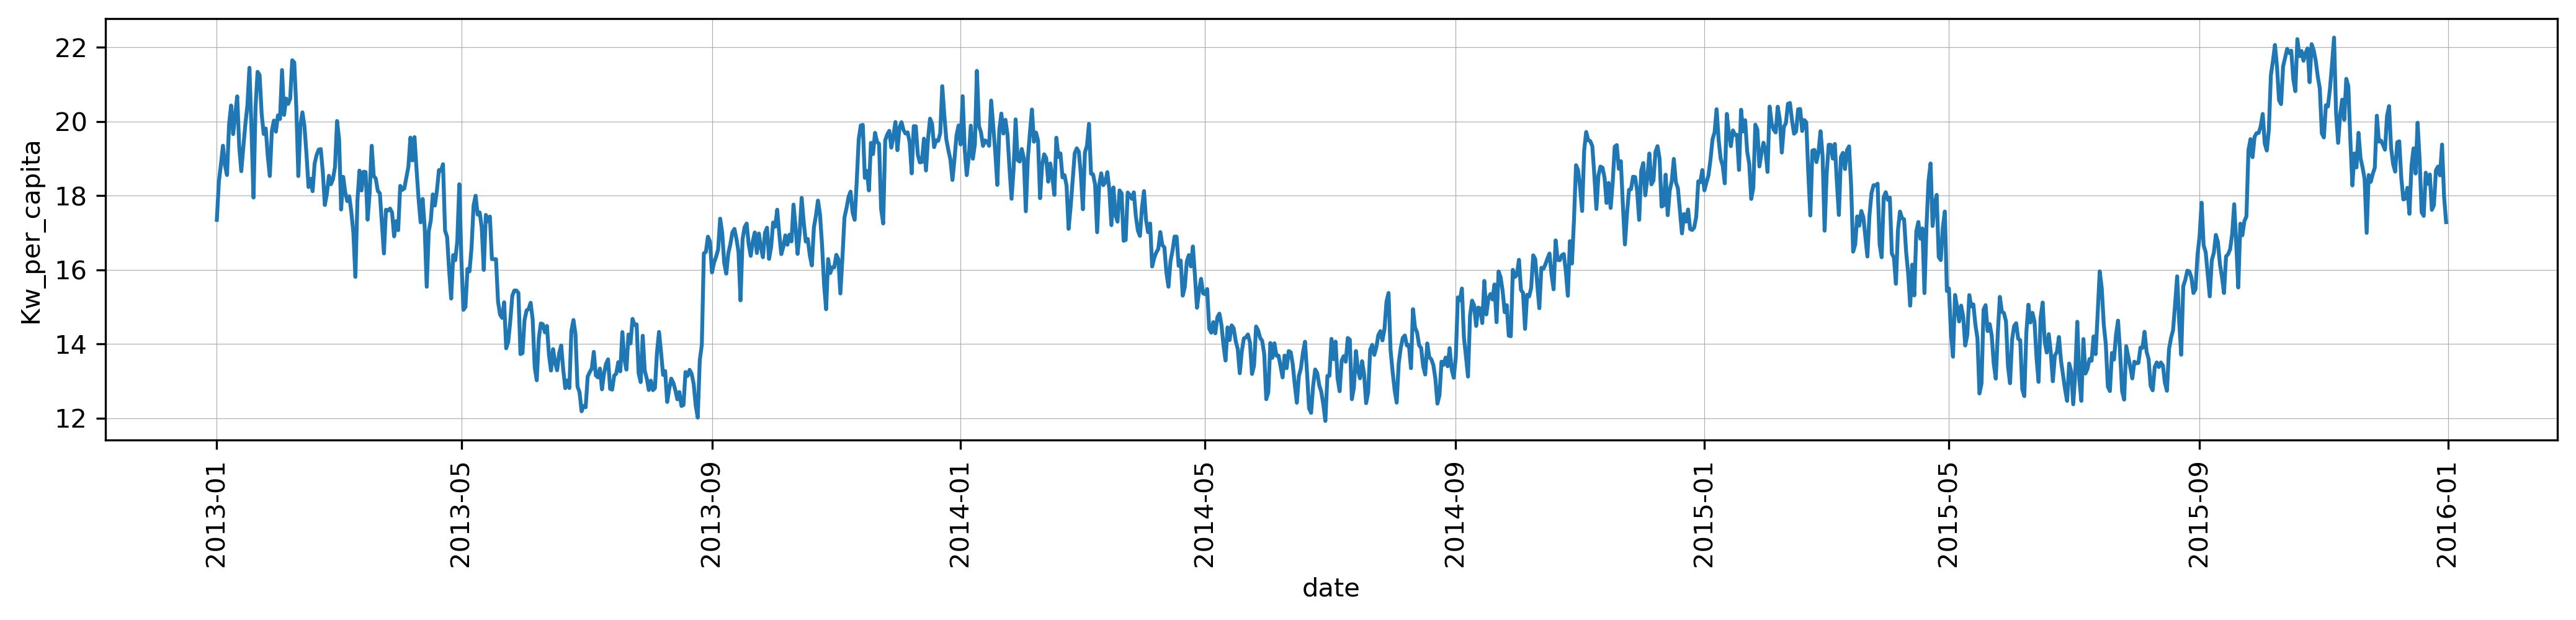

In [238]:
# plot time series
plt.rcParams.update({'figure.figsize': (17, 3), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=df1.head(5000), x='date', y='Kw_per_capita')
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)
# dfc.keys()

In [239]:
# see if there are any missing values
df1.isna().sum()

date             0
Kw_per_capita    0
dtype: int64

## Feature engineering

In [240]:
df1.head(3)

,date,Kw_per_capita
0,2013-01-01,17.345227
1,2013-01-02,18.375069
2,2013-01-03,18.837546


In [242]:
df1['3d']=df1['Kw_per_capita']
for i in range(len(df1)-2):
    s=df1['Kw_per_capita'][i]+df1['Kw_per_capita'][i+1]+df1['Kw_per_capita'][i+2]
#     print(s)
    df1['3d'][i+2]=s 

df1.head(10)

<ipython-input-242-de102f3001ae>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['3d'][i+2]=s


,date,Kw_per_capita,3d
0,2013-01-01,17.345227,17.345227
1,2013-01-02,18.375069,18.375069
2,2013-01-03,18.837546,54.557842
3,2013-01-04,19.345942,56.558557
4,2013-01-05,18.816000,56.999489
5,2013-01-06,18.555877,56.717819
6,2013-01-07,19.918158,57.290035
7,2013-01-08,20.430565,58.904600
8,2013-01-09,19.658347,60.007070
9,2013-01-10,20.177576,60.266488


In [246]:
df1['6d']=df1['Kw_per_capita']
for i in range(len(df1)-5):
    s=df1['Kw_per_capita'][i]+df1['Kw_per_capita'][i+1]+df1['Kw_per_capita'][i+2]+df1['Kw_per_capita'][i+3]+df1['Kw_per_capita'][i+4]+df1['Kw_per_capita'][i+5]
#     print(s)
    df1['6d'][i+5]=s

<ipython-input-246-0f85e953f98d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['6d'][i+5]=s


In [249]:
df1.head(10)

,date,Kw_per_capita,3d,6d
0,2013-01-01,17.345227,17.345227,17.345227
1,2013-01-02,18.375069,18.375069,18.375069
2,2013-01-03,18.837546,54.557842,18.837546
3,2013-01-04,19.345942,56.558557,19.345942
4,2013-01-05,18.816000,56.999489,18.816000
5,2013-01-06,18.555877,56.717819,111.275661
6,2013-01-07,19.918158,57.290035,113.848592
7,2013-01-08,20.430565,58.904600,115.904089
8,2013-01-09,19.658347,60.007070,116.724889
9,2013-01-10,20.177576,60.266488,117.556523


## Train-test split
**Problems:**
- ***we CAN't randomly split a time series with train_test_split(), because the split will randomly select points of time that appear in our train/test data set, which means the time is not continuous, or create gaps in time, this will disrupt the potential correlation exists in a time series.***
- the best to way to train-test split a time series is just take the early 80% as the train data, the following 20% as test data

In [252]:
# alternative train-test split 
# train_dataset, test_dataset = train_test_split(dfc, test_size=0.2)
train_data = df1[:int(df1.shape[0]*0.8)]
test_data = df1[int(df1.shape[0]*0.8):]

In [256]:
# train_data.sample(2)
test_data.sample(2)

,date,Kw_per_capita,3d,6d
952,2015-08-11,13.499978,39.619030,79.863512
1082,2015-12-19,17.551304,56.479664,113.145369


In [258]:
X_train = train_data.copy().drop(columns=['date','Kw_per_capita'])
X_test = test_data.copy().drop(columns=['date','Kw_per_capita'])

y_train = train_data.copy().pop('Kw_per_capita')
y_test = test_data.copy().pop('Kw_per_capita')

In [261]:
# X_train.sample(3)
y_train.sample(3)

66     17.558642
86     17.542973
277    16.421116
Name: Kw_per_capita, dtype: float64

In [262]:
# define the MAPE metric
def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [263]:
xgb_r = xgb.XGBRegressor(objective ='reg:squarederror',
                  n_estimators = 500, seed = 123)
  
xgb_r.fit(X_train, y_train)
xgb_r.fit(X_train, 
          y_train, 
         eval_set=[(X_train, y_train),(X_test, y_test)],
         eval_metric='mae')
  


[0]	validation_0-mae:11.38854	validation_1-mae:11.57854
[1]	validation_0-mae:7.98382	validation_1-mae:8.20693
[2]	validation_0-mae:5.59966	validation_1-mae:5.83523
[3]	validation_0-mae:3.92691	validation_1-mae:4.19368
[4]	validation_0-mae:2.75774	validation_1-mae:3.02043
[5]	validation_0-mae:1.93734	validation_1-mae:2.17610
[6]	validation_0-mae:1.36267	validation_1-mae:1.59566
[7]	validation_0-mae:0.97122	validation_1-mae:1.19838
[8]	validation_0-mae:0.71306	validation_1-mae:0.94088
[9]	validation_0-mae:0.55799	validation_1-mae:0.77722
[10]	validation_0-mae:0.46854	validation_1-mae:0.70348
[11]	validation_0-mae:0.41805	validation_1-mae:0.63999
[12]	validation_0-mae:0.38997	validation_1-mae:0.61467
[13]	validation_0-mae:0.37307	validation_1-mae:0.60001
[14]	validation_0-mae:0.36192	validation_1-mae:0.59006
[15]	validation_0-mae:0.35413	validation_1-mae:0.57577
[16]	validation_0-mae:0.34847	validation_1-mae:0.57059
[17]	validation_0-mae:0.34255	validation_1-mae:0.56881
[18]	validation_0-

[149]	validation_0-mae:0.07833	validation_1-mae:0.58955
[150]	validation_0-mae:0.07766	validation_1-mae:0.58954
[151]	validation_0-mae:0.07666	validation_1-mae:0.58964
[152]	validation_0-mae:0.07548	validation_1-mae:0.58916
[153]	validation_0-mae:0.07490	validation_1-mae:0.58919
[154]	validation_0-mae:0.07400	validation_1-mae:0.58921
[155]	validation_0-mae:0.07334	validation_1-mae:0.58922
[156]	validation_0-mae:0.07250	validation_1-mae:0.58946
[157]	validation_0-mae:0.07157	validation_1-mae:0.59005
[158]	validation_0-mae:0.07070	validation_1-mae:0.58986
[159]	validation_0-mae:0.06989	validation_1-mae:0.59071
[160]	validation_0-mae:0.06915	validation_1-mae:0.59093
[161]	validation_0-mae:0.06828	validation_1-mae:0.59105
[162]	validation_0-mae:0.06770	validation_1-mae:0.59111
[163]	validation_0-mae:0.06713	validation_1-mae:0.59120
[164]	validation_0-mae:0.06703	validation_1-mae:0.59138
[165]	validation_0-mae:0.06669	validation_1-mae:0.59069
[166]	validation_0-mae:0.06615	validation_1-mae:

[296]	validation_0-mae:0.02427	validation_1-mae:0.59825
[297]	validation_0-mae:0.02419	validation_1-mae:0.59825
[298]	validation_0-mae:0.02401	validation_1-mae:0.59838
[299]	validation_0-mae:0.02384	validation_1-mae:0.59839
[300]	validation_0-mae:0.02364	validation_1-mae:0.59850
[301]	validation_0-mae:0.02345	validation_1-mae:0.59859
[302]	validation_0-mae:0.02334	validation_1-mae:0.59854
[303]	validation_0-mae:0.02312	validation_1-mae:0.59856
[304]	validation_0-mae:0.02300	validation_1-mae:0.59858
[305]	validation_0-mae:0.02288	validation_1-mae:0.59857
[306]	validation_0-mae:0.02270	validation_1-mae:0.59854
[307]	validation_0-mae:0.02255	validation_1-mae:0.59856
[308]	validation_0-mae:0.02225	validation_1-mae:0.59861
[309]	validation_0-mae:0.02206	validation_1-mae:0.59858
[310]	validation_0-mae:0.02192	validation_1-mae:0.59855
[311]	validation_0-mae:0.02164	validation_1-mae:0.59852
[312]	validation_0-mae:0.02150	validation_1-mae:0.59849
[313]	validation_0-mae:0.02133	validation_1-mae:

[443]	validation_0-mae:0.00875	validation_1-mae:0.60104
[444]	validation_0-mae:0.00869	validation_1-mae:0.60105
[445]	validation_0-mae:0.00861	validation_1-mae:0.60105
[446]	validation_0-mae:0.00855	validation_1-mae:0.60105
[447]	validation_0-mae:0.00846	validation_1-mae:0.60110
[448]	validation_0-mae:0.00839	validation_1-mae:0.60115
[449]	validation_0-mae:0.00835	validation_1-mae:0.60117
[450]	validation_0-mae:0.00828	validation_1-mae:0.60113
[451]	validation_0-mae:0.00823	validation_1-mae:0.60113
[452]	validation_0-mae:0.00816	validation_1-mae:0.60116
[453]	validation_0-mae:0.00808	validation_1-mae:0.60116
[454]	validation_0-mae:0.00801	validation_1-mae:0.60119
[455]	validation_0-mae:0.00800	validation_1-mae:0.60119
[456]	validation_0-mae:0.00798	validation_1-mae:0.60120
[457]	validation_0-mae:0.00795	validation_1-mae:0.60120
[458]	validation_0-mae:0.00787	validation_1-mae:0.60125
[459]	validation_0-mae:0.00782	validation_1-mae:0.60123
[460]	validation_0-mae:0.00778	validation_1-mae:

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=500, n_jobs=8,
             num_parallel_tree=1, predictor='auto', random_state=123,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=123,
             subsample=1, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [264]:
# Predictions on the train dataset
train_pred = xgb_r.predict(X_train)
# RMSE Computation
train_rmse = np.sqrt(mean_squared_error(y_train, train_pred))
print("RMSE : % f" %(train_rmse))
train_pred[-5:-1]

RMSE :  0.008408


array([14.233408, 13.460885, 13.065323, 14.28152 ], dtype=float32)

In [270]:
# Predictions on the train dataset
test_pred = xgb_r.predict(X_test)
# RMSE Computation
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print("RMSE : % f" %(test_rmse))
test_pred[-5:-1]

RMSE :  0.754349


array([18.11816 , 18.33556 , 18.952381, 18.986805], dtype=float32)